# SuperflexPy example 06: Initialize complete (network) model

Author: Marco Dal Molin

Collaborators: Fabrizio Fenicia, Dmitri Kavetski

## What's in this example

This example will cover the following aspects:
- [Initialize a complete (network) model](https://superflexpy.readthedocs.io/en/latest/demo.html#multiple-nodes-in-a-network)
- [Relations between parameters in different nodes](https://superflexpy.readthedocs.io/en/latest/html/components.html#node)

By clicking on the items you will be redirected to the documentation page (when available) that explains the arguments in a more detailed way. 

## What's not in this example

The following aspects are already covered in other examples:

- [Initialize the nodes, the units, and the single elements contained](./05_init_single_node_model.ipynb)
- [Run the model](./01_run_simple_model.ipynb)
- [Change states and parameters](./01_run_simple_model.ipynb)

For this reason we will put only the code need, without further explanations. You can check the other examples by clicking on the items above.

## Do you want to use this example as a script?

Examples of SuperflexPy are created and distributed using Jupyter notebooks because they enable to conjugate runnable code with text explanations. We have decided to not provide the content of the notebooks as script because this would mean duplicating the same content in multiple places, bringing to maintainability problems.

If the user wants to download the content of this notebook as a python script, it is possible following the steps:
1. If not already done, open this notebook using [Binder](https://mybinder.org/v2/gh/dalmo1991/superflexPy/master?filepath=examples%2F06_init_complete_model.ipynb)
2. Go on File -> Download as -> Python (.py)
3. Select the saving path

The result is a Python script that contains all the markdown text as comment and the code contained inside the cells.

## STEP 1: Initialize the complete model

A complete model is composed by several nodes that operate sequentially, from upstream to downstream, within the network. In this example, we will consider a case where there are 2 upstream nodes that flow into a downstream one.

### 01. Import an initialize the numerical routines, the elements, the units, and the nodes

All the nodes contained in the network must be, first, initialized. This can be done with the following code.

In [1]:
from superflexpy.implementation.computation.pegasus_root_finding import PegasusPython
from superflexpy.implementation.computation.implicit_euler import ImplicitEulerPython
from superflexpy.implementation.elements.hbv import FastReservoir
from superflexpy.framework.unit import Unit
from superflexpy.framework.node import Node

# Initialize numercal routines
root_finder = PegasusPython()
numeric_approximator = ImplicitEulerPython(root_finder=root_finder)

# Initialize the elements
e1 = FastReservoir(
    parameters={'k': 0.1, 'alpha': 1.0},
    states={'S0': 10.0},
    approximation=numeric_approximator,
    id='E1'
)

e2 = FastReservoir(
    parameters={'k': 0.1, 'alpha': 1.0},
    states={'S0': 10.0},
    approximation=numeric_approximator,
    id='E2'
)

e3 = FastReservoir(
    parameters={'k': 0.1, 'alpha': 1.0},
    states={'S0': 10.0},
    approximation=numeric_approximator,
    id='E3'
)

u1 = Unit(
    layers=[
        [e1],
        [e2]
    ],
    id='U1'
)

u2 = Unit(
    layers=[
        [e3],
    ],
    id='U2'
)

node1 = Node(
    units=[u1, u2],
    weights=[0.7, 0.3],
    area=1.0,
    id='N1'
)

node2 = Node(
    units=[u1, u2],
    weights=[0.1, 0.9],
    area=2.0,
    id='N2'
)

node3 = Node(
    units=[u1],
    weights=[1.0],
    area=0.5,
    id='N3'
)

### 02. Initialize the network

Now that the nodes are all initialized, they can be added to a network to contribute together to its outflow.

In [2]:
from superflexpy.framework.network import Network

model = Network(
    nodes=[node1, node2, node3],
    topography={
        'N1': 'N3',
        'N2': 'N3',
        'N3': None,
    }
)

## STEP 2: Run the model

Now that the model has been initialized, it can be run. This can be done running the code in the following cell.

### 01. Assign the input to the nodes

Unlike the other components, the network does not have the method `set_input` because, due to their spatial distribution, the inputs are usually node specific. For
this reason the `set_input` method of the single nodes must be used.

In [3]:
import numpy as np

# Fix the seed
SEED = 2
rng = np.random.RandomState(seed=SEED)

# Generate the input
P1 = np.zeros(100)
P1[:10] = rng.randint(10, size=10)
P1[25:30] = rng.randint(20, size=5)
P1[40:60] = rng.randint(5, size=20)
P1[80:83] = rng.randint(30, 50, size=3)

# Assign the input
node1.set_input([P1])

# Generate the input
P2 = np.zeros(100)
P2[:10] = rng.randint(10, size=10)
P2[25:30] = rng.randint(20, size=5)
P2[40:60] = rng.randint(5, size=20)
P2[80:83] = rng.randint(30, 50, size=3)

# Assign the input
node2.set_input([P2])

# Generate the input
P3 = np.zeros(100)
P3[:10] = rng.randint(10, size=10)
P3[25:30] = rng.randint(20, size=5)
P3[40:60] = rng.randint(5, size=20)
P3[80:83] = rng.randint(30, 50, size=3)

# Assign the input
node3.set_input([P3])

### 02. Run the model

Apart from this difference, now the network can be run as in the previous examples.

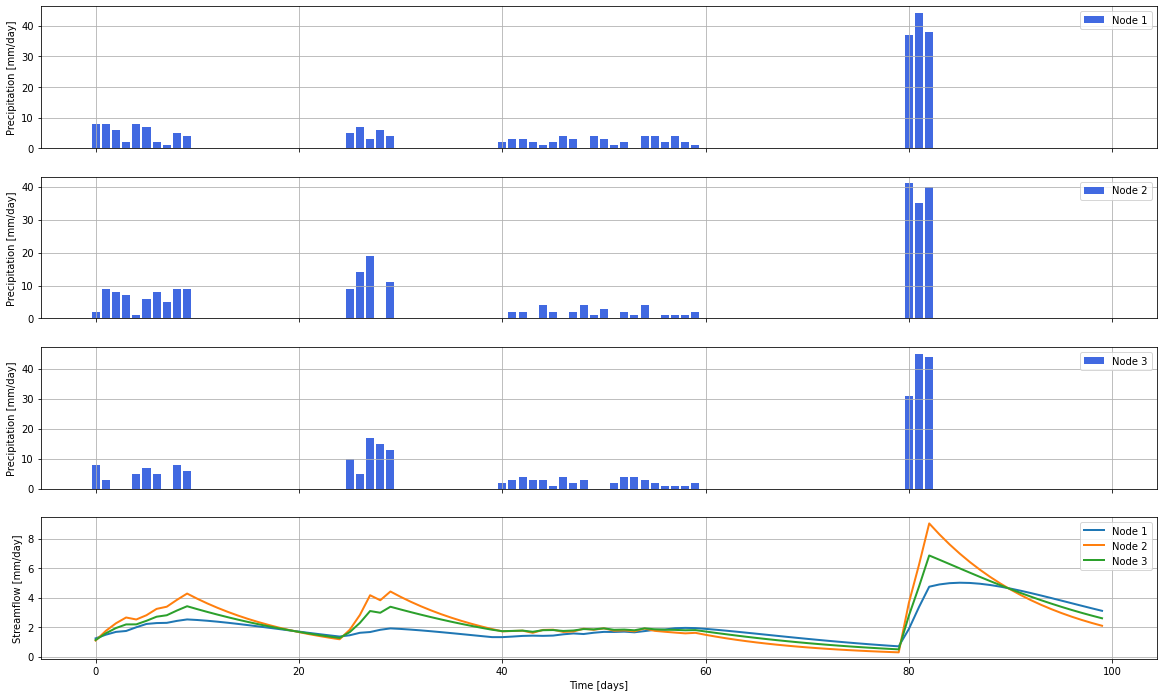

In [4]:
import matplotlib.pyplot as plt

# Set the timestep
model.set_timestep(1.0)

# Run the model
output = model.get_output()

# Plot
fig, ax = plt.subplots(4, 1, figsize=(20, 12), sharex=True)
ax[0].bar(x=np.arange(len(P1)), height=P1, color='royalblue', label='Node 1')
ax[0].set_ylabel('Precipitation [mm/day]')
ax[0].legend()
ax[0].grid(True)
ax[1].bar(x=np.arange(len(P2)), height=P2, color='royalblue', label='Node 2')
ax[1].set_ylabel('Precipitation [mm/day]')
ax[1].legend()
ax[1].grid(True)
ax[2].bar(x=np.arange(len(P3)), height=P3, color='royalblue', label='Node 3')
ax[2].set_ylabel('Precipitation [mm/day]')
ax[2].legend()
ax[2].grid(True)
ax[3].plot(np.arange(len(P1)), output['N1'][0], lw=2, label='Node 1')
ax[3].plot(np.arange(len(P1)), output['N2'][0], lw=2, label='Node 2')
ax[3].plot(np.arange(len(P1)), output['N3'][0], lw=2, label='Node 3')
ax[3].set_xlabel('Time [days]')
ax[3].set_ylabel('Streamflow [mm/day]')
ax[3].legend()
ax[3].grid(True)
pass

## STEP 3: Shared parameters

As explained in the [documentation](TODO), it may be useful to share the parameters of the elements contained in the same units among different nodes. This is the default behavior of SuperflexPy that can be avoided setting the parameter `shared_parameters`  to `False` when initializing the node.

### 01. Parameter identifiers

When parameters are shared, their identifier does not contain the `id` of the node since, in practice, they do not belong to a specific node, but just to the unit.

In [5]:
print(model.get_parameters_name())

['U1_E1_k', 'U1_E1_alpha', 'U1_E2_k', 'U1_E2_alpha', 'U2_E3_k', 'U2_E3_alpha']


### 02. Changing parameters

When the value of a parameter is changed in a node then this change affects also the other nodes that contain that unit.

In [6]:
print('Value of U1_E1_k in node 2')
print(node2.get_parameters(['U1_E1_k']))
print('Changing U1_E1_k in node 1')
node1.set_parameters({'U1_E1_k': 0.2})
print('Value of U1_E1_k in node 1')
print(node1.get_parameters(['U1_E1_k']))
print('Value of U1_E1_k in node 2')
print(node2.get_parameters(['U1_E1_k']))

Value of U1_E1_k in node 2
{'U1_E1_k': 0.1}
Changing U1_E1_k in node 1
Value of U1_E1_k in node 1
{'U1_E1_k': 0.2}
Value of U1_E1_k in node 2
{'U1_E1_k': 0.2}


### 03. States are node specific

This concept does not apply to states, which are node specific.

In [7]:
print(model.get_states())

{'N1_U1_E1_S0': 19.999120153768562, 'N1_U1_E2_S0': 35.72775045588256, 'N1_U2_E3_S0': 19.999120153768562, 'N2_U1_E1_S0': 19.361104159818524, 'N2_U1_E2_S0': 34.41306375395972, 'N2_U2_E3_S0': 19.361104159818524, 'N3_U1_E1_S0': 20.32805564377347, 'N3_U1_E2_S0': 36.16914805775058}
